# Preamble

In [ ]:
import torch
import numpy as np
import seaborn as sns
import scipy.sparse as sp
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from torch_geometric.data import Data
import torch_geometric.transforms as T

from interception_smoothing.datasets import load_dataset
from interception_smoothing.models import AblationGAT
from interception_smoothing.training import training_inductive
from interception_smoothing.prediction import smoothed_gnn
from interception_smoothing.utils import compute_certificates

# Model

In [ ]:
hparams = {
    "device": "cuda",

    "dataset": "cora_ml",

    "p_train_nodes": 0.7,
    "p_train_edges": 0.1,

    "p_eval_nodes": 0.794,  # p_a in the paper (feature ablation probability)
    "p_eval_edges": 0.361449,  # p_d in the paper (edge deletion probability)

    'n0': 1_000,
    'n1': 3_000,

    'lr': 0.001,
    'weight_decay': 5e-4,
    "max_epochs": 1_000,
    "logging": True,
    "k_heads": 8,
    "hidden_channels": 8,
    "p_dropout_skip": 0.9,
    "p_dropout": 0.5,
    "with_skip": True,
    "alpha": 0.01,
    "early_stopping": 50,
}

In [ ]:
dataset = load_dataset(hparams["dataset"])
[A, X, y, n, d, nc, train, valid, test, idx_train, idx_valid, idx_test] = dataset

In [ ]:
hparams["in_channels"] = d
hparams["out_channels"] = nc

In [ ]:
edge_idx = torch.tensor(np.array(train[0].nonzero()), dtype=torch.long)
x = torch.tensor(train[1])
y = torch.LongTensor(train[2])
data_train = Data(A=train[0], x=x, edge_index=edge_idx, y=y)

edge_idx = torch.tensor(np.array(valid[0].nonzero()), dtype=torch.long)
x = torch.tensor(valid[1])
y = torch.LongTensor(valid[2])
data_valid = Data(A=valid[0], x=x, edge_index=edge_idx, y=y)

edge_idx = torch.tensor(np.array(test[0].nonzero()), dtype=torch.long)
x = torch.tensor(test[1])
y = torch.LongTensor(test[2])
data_test = Data(A=test[0], x=x, edge_index=edge_idx, y=y)

for data in [data_train, data_valid, data_test]:
    data.to(hparams['device'])

In [ ]:
# for training:
# model = AblationGAT(hparams).to(hparams['device'])
# args = model, data_train, data_valid, idx_train, idx_valid, hparams
# model = training_inductive(*args)

# load pretrained model (GAT on cora_ml)
model = torch.load("data/pretrained_models/pretrained_GAT_cora_ml.pt")
model.to(hparams['device'])

AblationGAT(
  (conv1): GATConv(2879, 8, heads=8)
  (conv2): GATConv(64, 7, heads=1)
  (ablate): AblationLayer()
)

In [ ]:
pre_votes = smoothed_gnn(model, data_test, nc, hparams["n0"])
votes = smoothed_gnn(model, data_test, nc, hparams["n1"])

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

# Certificate

In [ ]:
certificates = {}

for distance in [1, 2]:
    certificates[distance] = compute_certificates(model, None, None,
                                                  pre_votes, votes,
                                                  data_test, n, nc,
                                                  idx_test, hparams,
                                                  distance)

  0%|          | 0/2810 [00:00<?, ?it/s]

  0%|          | 0/2810 [00:00<?, ?it/s]

In [ ]:
round(certificates[1]['clean_acc'], 2)

0.81

In [ ]:
round(certificates[1]['abstain_ratio'],2)  # ratio of abstained predictions

0.03

In [ ]:
sns.set_style("whitegrid")
sns.set_context("notebook")

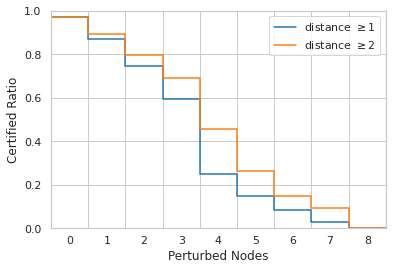

In [ ]:
fig, ax = plt.subplots(1, 1)

for label in certificates:
    cert = certificates[label]
    label = "distance $\geq$" + str(label)
    x, y = list(zip(*cert["cert_ratio"].items()))
    plt.step(x, y, where="post", label=label)

end = np.argmin(np.array(y)[:100] > 0) + 1
plt.xlim((0, end))
plt.ylim((0, 1.0))
xticks = np.arange(end)
plt.xticks(xticks)
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_locator(ticker.FixedLocator(xticks + 0.5))
ax.xaxis.set_minor_formatter(ticker.FixedFormatter(xticks))
ax.set_xlabel("Perturbed Nodes")
ax.set_ylabel("Certified Ratio")
ax.legend()
plt.show()

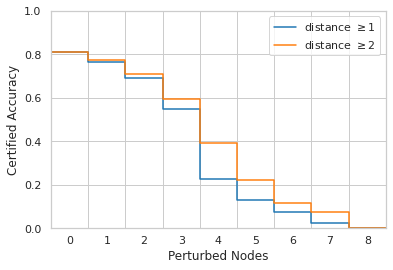

In [ ]:
fig, ax = plt.subplots(1, 1)

for label in certificates:
    cert = certificates[label]
    label = "distance $\geq$" + str(label)
    x, y = list(zip(*cert["cert_acc"].items()))
    plt.step(x, y, where="post", label=label)

end = np.argmin(np.array(y)[:100] > 0) + 1
plt.xlim((0, end))
plt.ylim((0, 1.0))

xticks = np.arange(end)
plt.xticks(xticks)
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_locator(ticker.FixedLocator(xticks+0.5))
ax.xaxis.set_minor_formatter(ticker.FixedFormatter(xticks))
ax.set_xlabel("Perturbed Nodes")
ax.set_ylabel("Certified Accuracy")
ax.legend()
plt.show()

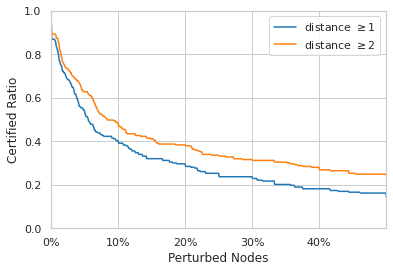

In [ ]:
fig, ax = plt.subplots(1, 1)

for label in certificates:
    cert = certificates[label]
    label = "distance $\geq$" + str(label)
    x, y = cert["cert_ratio_curve"]
    plt.plot(x, y, label=label)

plt.xlim((0, 0.5))
plt.ylim((0, 1.0))

xticks = [str(int(k*100)) + "%" for k in np.arange(0, 0.5, 0.1)]
plt.xticks(np.arange(0, 0.5, 0.1))
ax.set_xticklabels(xticks)
ax.set_xlabel("Perturbed Nodes")
ax.set_ylabel("Certified Ratio")
ax.legend()
plt.show()

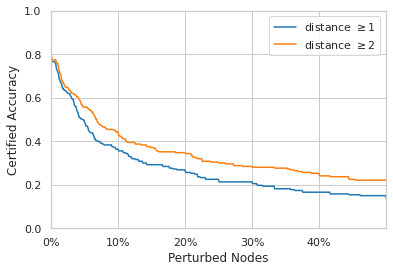

In [ ]:
fig, ax = plt.subplots(1, 1)

for label in certificates:
    cert = certificates[label]
    label = "distance $\geq$" + str(label)
    x, y = cert["cert_acc_curve"]
    plt.plot(x, y, label=label)

plt.xlim((0, 0.5))
plt.ylim((0, 1.0))

xticks = [str(int(k*100)) + "%" for k in np.arange(0, 0.5, 0.1)]
plt.xticks(np.arange(0, 0.5, 0.1))
ax.set_xticklabels(xticks)
ax.set_xlabel("Perturbed Nodes")
ax.set_ylabel("Certified Accuracy")

ax.legend()
plt.show()

# Sparsification

In [ ]:
gdc = T.GDC(sparsification_kwargs={'eps': 0.022, 'method': 'threshold'})

data_test = gdc(data_test)
data_test.cpu()
data = (np.ones(data_test.edge_index.shape[1]), data_test.edge_index)
data_test.A = sp.csr_matrix(data, shape=(n, n))
data_test.to(hparams["device"])
data_test.edge_attr = None

In [ ]:
pre_votes = smoothed_gnn(model, data_test, nc, hparams["n0"])
votes = smoothed_gnn(model, data_test, nc, hparams["n1"])

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

In [ ]:
certificates_sp = compute_certificates(model, None, None,
                                           pre_votes, votes,
                                           data_test, n, nc,
                                           idx_test, hparams, 2)

In [ ]:
round(certificates_sp["clean_acc"], 2)

In [ ]:
fig, ax = plt.subplots(1, 1)

for sparse in [True, False]:
    cert = certificates_sp if sparse else certificates[2]
    label = "Sparsification: " + str(sparse)
    x, y = list(zip(*cert["cert_ratio"].items()))
    plt.step(x, y, where="post", label=label)

end = np.argmin(np.array(y)[:100] > 0) + 1
plt.xlim((0, end))
plt.ylim((0, 1.0))
xticks = np.arange(end)
plt.xticks(xticks)
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_locator(ticker.FixedLocator(xticks + 0.5))
ax.xaxis.set_minor_formatter(ticker.FixedFormatter(xticks))
ax.set_xlabel("Perturbed Nodes")
ax.set_ylabel("Certified Ratio")
ax.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1)

for sparse in [True, False]:
    cert = certificates_sp if sparse else certificates[2]
    label = "Sparsification: " + str(sparse)
    x, y = cert["cert_ratio_curve"]
    plt.plot(x, y, label=label)

plt.xlim((0, 0.5))
plt.ylim((0, 1.0))

xticks = [str(int(k*100)) + "%" for k in np.arange(0, 0.5, 0.1)]
plt.xticks(np.arange(0, 0.5, 0.1))
ax.set_xticklabels(xticks)
ax.set_xlabel("Perturbed Nodes")
ax.set_ylabel("Certified Ratio")
ax.legend()
plt.show()